In [1]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from numpy import exp, ndarray
import pandas as pd

In [2]:
def download_data(name1: str, name2: str, start: str, end: str):
  data1 = yf.download(name1, start=start, end=end, interval = "1d")
  data2 = yf.download(name2, start=start, end=end, interval = "1d")
  s1 = data1['Close']
  s2 = data2['Close']
  return s1, s2

def simulate_ou(x0, mu, theta, sigma, dt, n):
  # Simulate an OU process.    
  x = np.zeros(n)
  x[0] = x0
  exp_minus_mu_deltat = exp(- mu * dt) 
  # Calculate the random term. 
  if mu == 0:
    # Handle the case of mu = 0 i.e. no mean reversion. 
    dWt = np.sqrt(dt) * np.random.randn(n)
  else:
    dWt = np.sqrt((1 - exp(-2*mu*dt))/(2 * mu)) * np.random.randn(n)
  # And iterate through time calculating each price. 
  for t in range(n)[1:]:   
    x[t] = x[t-1] * exp_minus_mu_deltat + theta * (1 - exp_minus_mu_deltat) + sigma * dWt[t]
  return x

In [3]:
def find_minimum(x, C):
    n = x.size
    s = np.std(x)
    index_min = []
    # Check the first point
    j = 1
    res = False
    while j < n:
        if x[j] >= x[0] and x[j] - x[0] > C*s:
            res = True
            break
        if x[j] < x[0]:
            res = False
            break
        if x[j] >= x[0] and x[j] - x[0] < C*s:
            j += 1
    if res:
        index_min.append(0)
    # Check inner points
    for i in range(1, (n-1)):
        # test the left values
        j = 1
        res_left = False
        while i-j >= 0:
            if x[i-j] >= x[i] and x[i-j] - x[i] > C*s:
                res_left = True
                break
            if x[i-j] < x[i]:
                res_left = False
                break
            if x[i-j] >= x[i] and x[i-j] - x[i] < C*s:
                j += 1
        # test the right values
        j = 1
        res_right = False
        while i+j <= n-1:
            if x[i+j] >= x[i] and x[i+j] - x[i] > C*s:
                res_right = True
                break
            if x[i+j] < x[i]:
                res_right = False
                break
            if x[i+j] >= x[i] and x[i+j] - x[i] < C*s:
                j += 1
        # If both left and right results are true, append index          
        if res_left and res_right:
            index_min.append(i)
    # Check the last point
    j = 1
    res = False
    while n-1-j > -1:
        if x[n-1-i] >= x[n-1] and x[n-1-i] - x[n-1] > C*s:
            res = True
            break
        if x[n-1-i] < x[n-1]:
            res = False  
            break
        if x[n-1-i] >= x[n-1] and x[n-1-i] - x[n-1] < C*s:
            i += 1
    if res:
        index_min.append(n-1)

    return index_min

def find_maximum(x, C):
    n = x.size
    s = np.std(x)
    index_max = []
    # Check the first point
    j = 1
    res = False
    while j < n:
        if x[j] <= x[0] and x[0] - x[j] > C*s:
            res = True
            break
        if x[j] > x[0]:
            res = False
            break
        if x[j] <= x[0] and x[0] - x[j] < C*s:
            j += 1
    if res:
        index_max.append(0)
    # Check inner points
    for i in range(1, (n-1)):
        # test the left values
        res_left = False
        j = 1
        while i-j >= 0:
            if x[i-j] <= x[i] and x[i] - x[i-j] > C*s:
                res_left = True
                break
            if x[i-j] > x[i]:
                res_left = False
                break
            if x[i-j] <= x[i] and x[i] - x[i-j] < C*s:
                j += 1
        # test the right values
        res_right = False
        j = 1
        while i+j <= n-1:
            if x[i+j] <= x[i] and x[i] - x[i+j] > C*s:
                res_right = True
                break
            if x[i+j] > x[i]:
                res_right = False
                break
            if x[i+j] <= x[i] and x[i] - x[i+j] < C*s:
                j += 1
        # If both left and right results are true, append index          
        if res_left and res_right:
            index_max.append(i)
    # Check the last point
    j = 1
    res = False
    while n-1-j > -1:
        if x[n-1-j] <= x[n-1] and x[n-1] - x[n-1-j] > C*s:
            res = True
            break
        if x[n-1-j] > x[n-1]:
            res = False  
            break
        if x[n-1-j] <= x[n-1] and x[n-1] - x[n-1-j] < C*s:
            j += 1
    if res:
        index_max.append(n-1)  
    return index_max

def get_mean_reverse_time(x: ndarray, C):
    # compute the index of important extremum and num
    index_min = find_minimum(x, C)
    index_max = find_maximum(x, C)
    num_extre = len(index_min) + len(index_max)
    # compute the reversion time
    theta = np.mean(x)
    total_reverse_time = 0
    # compute the total reversion time of minimums
    for start_index in index_min:
        reverse_index = start_index
        while reverse_index < len(x)-1:
            if x[reverse_index] < theta and x[reverse_index+1] > theta:
                break
            else:
                reverse_index += 1
        total_reverse_time += reverse_index - start_index
    # compute the total reversion time of maximums
    for start_index in index_max:
        reverse_index = start_index
        while reverse_index < len(x)-1:
            if x[reverse_index] > theta and x[reverse_index+1] < theta:
                break
            else:
                reverse_index += 1
        total_reverse_time += reverse_index - start_index
    # compute mean reverse time
    if num_extre > 0:
        mean_reverse_time = total_reverse_time / num_extre 
    else:
        mean_reverse_time = 0
    return mean_reverse_time

def get_optimal_ratio(s1: ndarray, s2: ndarray, C):
    b_list = np.arange(200) / 100
    reverse_time_list = np.zeros(200)
    for i in range(200):
        x = s1 - b_list[i] * s2
        reverse_time_temp = get_mean_reverse_time(x, C) 
        reverse_time_list[i] = reverse_time_temp
    b_best = b_list[np.argmin(reverse_time_list)]
    return b_best

def construct_spread(s1, s2, L, C):
  '''
  s1: the first stock
  s2: the second storck
  L: the length of historical data used to estimate the best ratio
  '''
  n = s1.size
  x = np.zeros(n - L)
  b_list = np.zeros(n - L)
  for i in range(L, n):
    s1_train = s1[i - L : i]
    s2_train = s2[i - L : i]  
    b = get_optimal_ratio(s1_train, s2_train, C) 
    x[i - L] = s1[i] - b * s2[i]
    b_list[i - L] = b
  return s1[L:], s2[L:], x, b_list

In [4]:
def dynamic_trade_OU(s1: ndarray, s2: ndarray, x: ndarray, init_cash, M, thres):
  '''
  s1: the first stock price series, 1d
  s2: the second storck price series, 1d
  x: spread
  b: best ratio list (s1, s2, x and b have same length)
  init_cash: the amount of money we invest at the beginning
  L: the length of historical data used to compute MA and SD of spreads
  level: the threshold or the width of band
  '''
  n = s1.size
  cash = init_cash
  shares = 0
  num_trades = 0
  equity_list = np.zeros(n) + init_cash
  shares_list = np.zeros(n) 
  for i in range(M, n):
    # Trading criterions
    # Enter position
    if shares == 0 and x[i] < np.average(x[i - M:i]) - thres * np.std(x[i - M:i]):
      shares = cash / s1[i]
      cash = cash - shares * x[i]  
      num_trades += 1

    # Exit position
    if shares > 0 and x[i] > np.average(x[i - M:i]) + thres * np.std(x[i - M:i]):
      cash = cash + shares * x[i]  
      shares = 0
      num_trades += 1

    # Record the change of position
    equity_list[i] = cash + shares * x[i] 
    shares_list[i] = shares
 
  return equity_list[M:], shares_list[M:], num_trades

def summarize_total_equity(x):
  '''
  This function is to summarize the statistics of a equity curve
  x: the total equity curve
  '''
  returns = (x[1:] - x[:-1]) / x[:-1]
  daily_return = np.mean(returns) 
  daily_std = np.std(returns)
  daily_sharpe = daily_return / daily_std
  annual_ret = 252 * daily_return
  annual_std = 252**(1/2) * daily_std
  annual_sharpe = 252**(1/2) * daily_sharpe
  max_drawdown = (np.min(x) - x[0]) / x[0]
  cumul_pnl = (x[-1] - x[0]) / x[0]  
  result = {'DailyRet': daily_return,
            'DailyStd': daily_std,
            'DailySharp': daily_sharpe,
            'AnnualRet': annual_ret, 
            'AnnualStd': annual_std,
            'AnnualSharpe': annual_sharpe,
            'MaxDrawdown': max_drawdown,
            'CumulPnL': cumul_pnl,
            }
  return result

3.0776699029126213


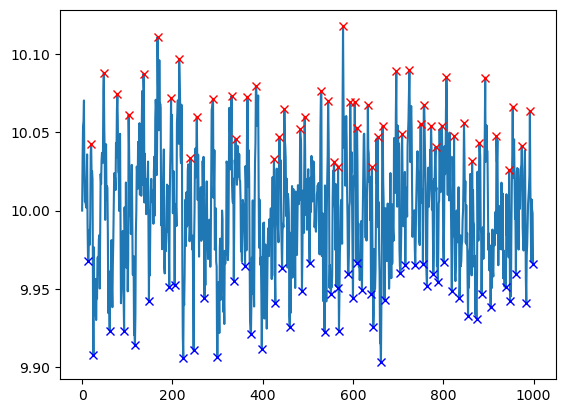

In [5]:
# Test find extreme value algorithm
C = 2
t = np.arange(0, 1000)
x = simulate_ou(10, mu=100, theta=10, sigma=0.5, dt=1/250, n=1000)
plt.plot(t, x)
print(get_mean_reverse_time(x, C))
index_min = find_minimum(x, C)
plt.plot(t[index_min], x[index_min], 'bx')
index_max = find_maximum(x, C)
plt.plot(t[index_max], x[index_max], 'rx')
plt.show()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


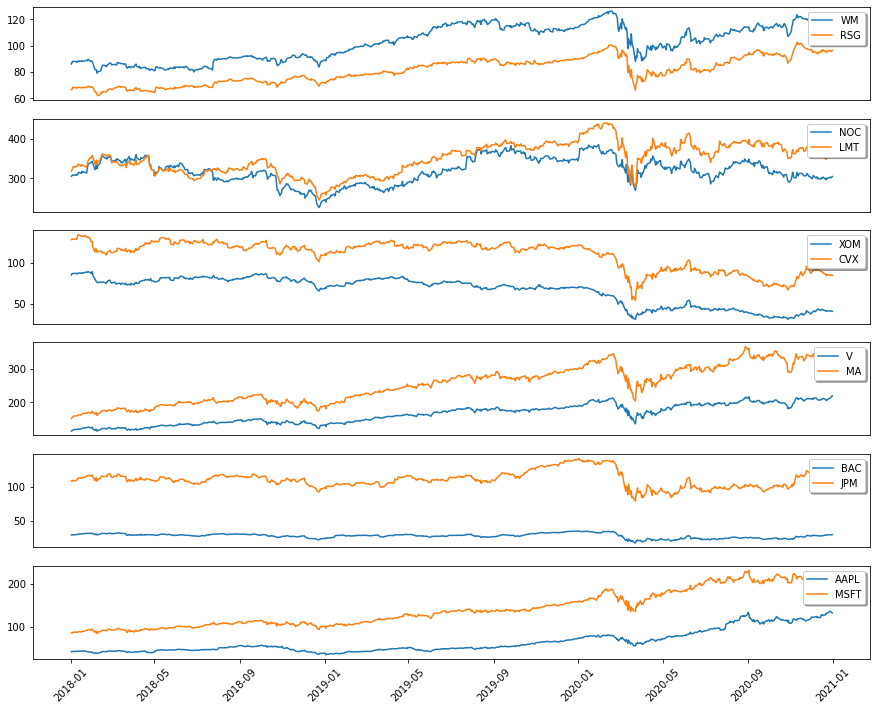

In [9]:
# %% Real Market Example #############
# Download data
dt = 1/252
data = {'WM-RSG':[], 'NOC-LMT':[], 'XOM-CVX':[], 'V-MA':[], 'BAC-JPM':[], 'AAPL-MSFT':[]}
for key in data:
  # get data
  name1, name2 = key.split('-')
  s1, s2 = download_data(name1, name2, "2018-01-01", "2021-01-01")
  # Store s1, s2 to data
  data[key] = pd.concat([s1, s2], keys=['s1', 's2'], axis=1)

# plot the prices of stock pairs
fig, ax = plt.subplots(6)
fig.set_size_inches(15, 12)
i = 0
for key in data:
  name1, name2 = key.split('-')
  ax[i].plot(data[key]['s1'], label=name1)
  ax[i].plot(data[key]['s2'], label=name2)
  ax[i].get_xaxis().set_visible(False)
  ax[i].legend(loc='upper right', shadow=True)
  i += 1
ax[5].get_xaxis().set_visible(True)
plt.xticks(rotation=45)
plt.show()

In [10]:
########### Trading Baseline method: trade equilly ########################
# Formation Period
# hyper-parameters
C = 0.1
L = 252
s1 = {}
s2 = {}
x = {} 
b = {}
# compute best ratio for each pairs
k = 0
for key in data:
  s1[key], s2[key], x[key], b[key] = construct_spread(data[key]['s1'][-534:], data[key]['s2'][-534:], L, C)
  k += 1 

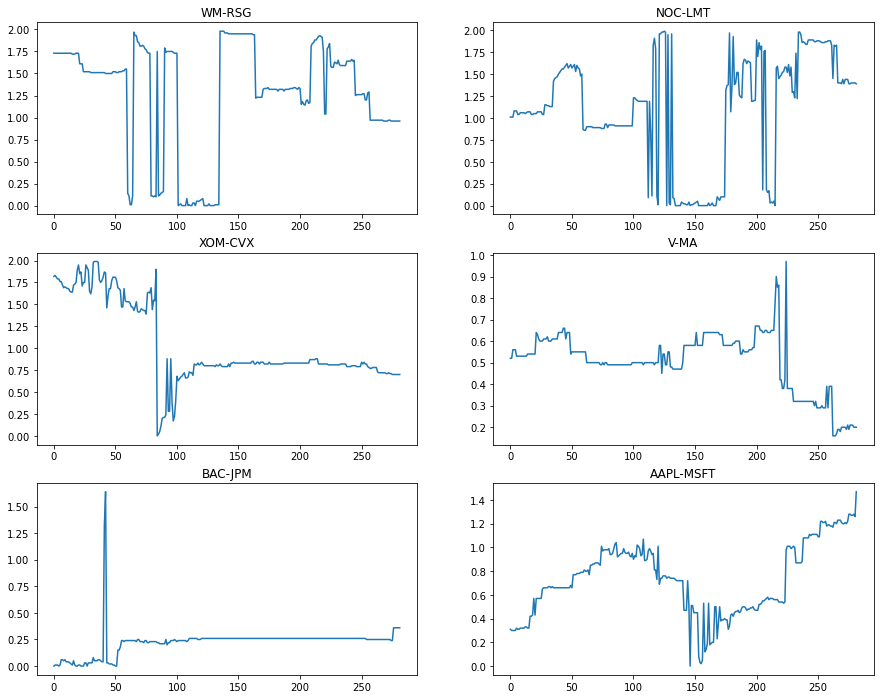

In [16]:
n = 282
fig, axs = plt.subplots(3, 2)
fig.set_size_inches(15, 12)
axs[0, 0].plot(np.arange(n), b['WM-RSG'])
axs[0, 0].title.set_text('WM-RSG')
axs[0, 1].plot(np.arange(n), b['NOC-LMT'])
axs[0, 1].title.set_text('NOC-LMT')
axs[1, 0].plot(np.arange(n), b['XOM-CVX'])
axs[1, 0].title.set_text('XOM-CVX')
axs[1, 1].plot(np.arange(n), b['V-MA'])
axs[1, 1].title.set_text('V-MA')
axs[2, 0].plot(np.arange(n), b['BAC-JPM'])
axs[2, 0].title.set_text('BAC-JPM')
axs[2, 1].plot(np.arange(n), b['AAPL-MSFT'])
axs[2, 1].title.set_text('AAPL-MSFT')
plt.show()

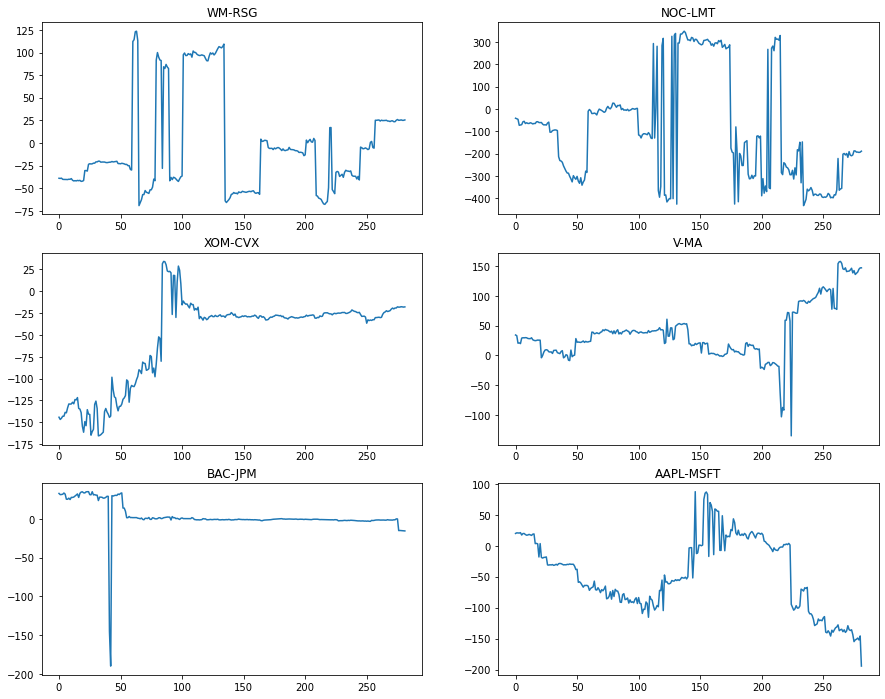

In [17]:
n = 282
fig, axs = plt.subplots(3, 2)
fig.set_size_inches(15, 12)
axs[0, 0].plot(np.arange(n), x['WM-RSG'])
axs[0, 0].title.set_text('WM-RSG')
axs[0, 1].plot(np.arange(n), x['NOC-LMT'])
axs[0, 1].title.set_text('NOC-LMT')
axs[1, 0].plot(np.arange(n), x['XOM-CVX'])
axs[1, 0].title.set_text('XOM-CVX')
axs[1, 1].plot(np.arange(n), x['V-MA'])
axs[1, 1].title.set_text('V-MA')
axs[2, 0].plot(np.arange(n), x['BAC-JPM'])
axs[2, 0].title.set_text('BAC-JPM')
axs[2, 1].plot(np.arange(n), x['AAPL-MSFT'])
axs[2, 1].title.set_text('AAPL-MSFT')
plt.show()

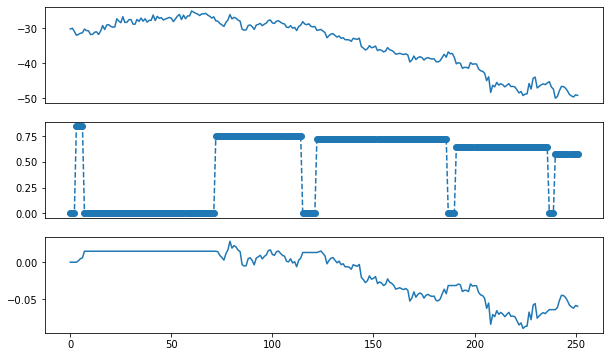

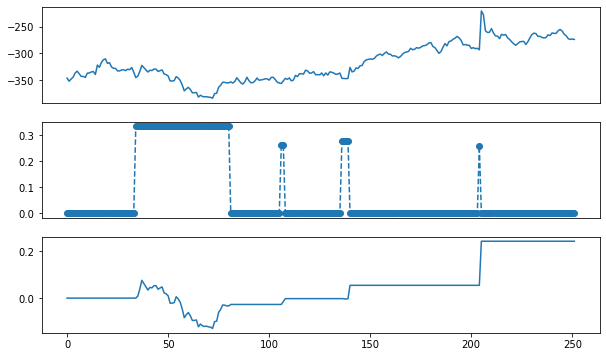

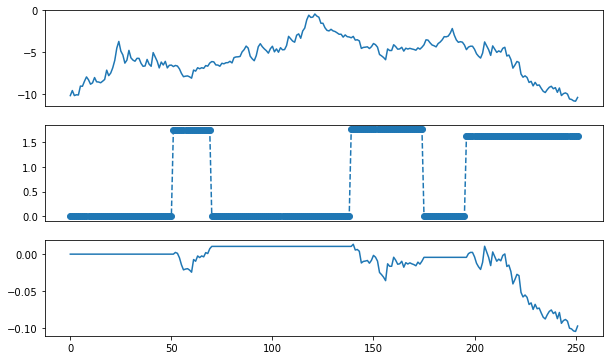

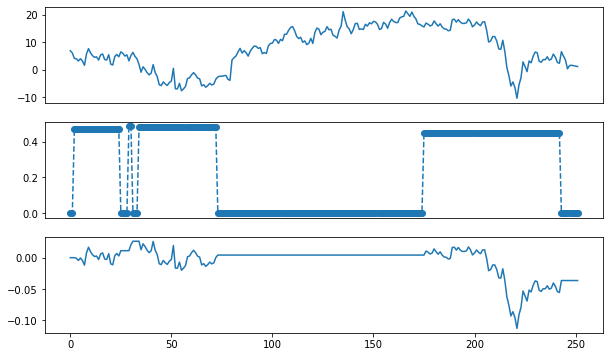

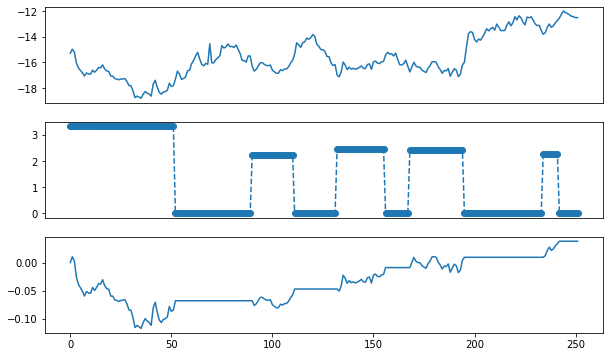

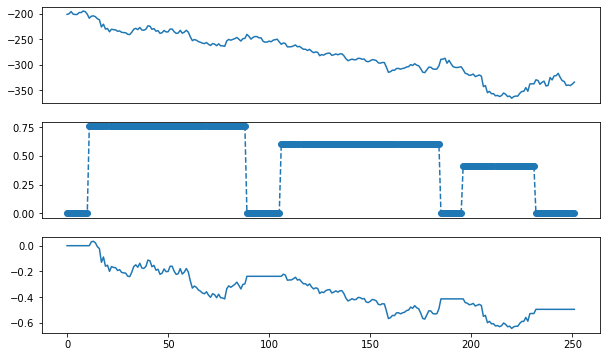

In [64]:
# Trading seperately
thres = 1
init_cash = 100
M = 30
equity = {}
shares = {}
num_trades = {}
k = 0
for key in data:
    equity[key], shares[key], num_trades[key] = dynamic_trade_OU(s1[key], s2[key], x[key], b[key], init_cash, M, thres)
    k += 1
# Visualization
k = 0
for key in data:
  plt.rcParams["figure.figsize"] = (10, 6)
  fig, ax = plt.subplots(3)
  # plot the spread
  ax[0].plot(np.arange(n), x[key][-n:])
  ax[0].get_xaxis().set_visible(False)
  # plot the position change
  ax[1].scatter(np.arange(n), shares[key][-n:])
  ax[1].plot(np.arange(n), shares[key][-n:], '--')
  ax[1].get_xaxis().set_visible(False)
  # plot equity curve
  ax[2].plot(np.arange(n), equity[key][-n:]/equity[key][-n] - 1)
  k += 1
  plt.show()

In [ ]:
# summary of wealth curve
for key in equity:
    print(summarize_total_equity(equity[key]))
    num_trades[key]